# Which months to use for the adiabatic theory?
The most severe approximation in the adiabatic theory is that $\Delta q_A(x) \approx \overline{\alpha_A}\overline{q^*_A}\Delta T_A$. Below, we see how this approximation varies with the months used for the $\kappa=1$ simulation.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import (get_temp_adiabat, get_delta_mse_mod_anom_theory, 
                                              decompose_temp_adiabat_anomaly, get_delta_temp_quant_theory, get_delta_temp_quant_theory_simple)
from isca_tools.utils.stats import z_score_from_confidence_interval
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
from sklearn.linear_model import TheilSenRegressor
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-04-25 12:55:13,126 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum']        # only keep variables required to compute relative humidity and MSE
# var_keep = ['temp', 'sphum', 'height', 'ucomp', 'vcomp']
# Load dataset
tau_lw_ref = 1
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'tau_sweep/aquaplanet/'
exp_name = f"k={str(tau_lw_ref).replace('.','_')}"
ds = []
albedo = []
tau_sw = []
tau_lw = []
ds = isca_tools.load_dataset(exp_dir + exp_name)[var_keep]
namelist = isca_tools.load_namelist(exp_dir + exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau_sw = namelist['two_stream_gray_rad_nml']['atm_abs']
tau_lw = namelist['two_stream_gray_rad_nml']['odp']

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.


In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)

# Tropics
lat_lims = {'tropics': [0, 20], 'extratropics': [40, 65]}
season_months = {'all': {'nh': np.arange(1, 13), 'sh': np.arange(1, 13)}, 
                 '6_summer': {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}, 
                 '6_winter': {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}, 
                 '3_summer': {'nh': [6, 7, 8], 'sh': [12, 1, 2]}, 
                 '3_winter': {'sh': [6, 7, 8], 'nh': [12, 1, 2]}}
n_regions = len(lat_lims)
n_seasons = len(season_months)

ds_all = {key: {} for key in lat_lims}
with tqdm(total=n_regions*n_seasons, position=0, leave=True) as pbar:
    for region in lat_lims:
        ds_use = ds.sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.sel(pfull=np.inf, method='nearest')     # only keep the surface values - get rid of pfull coordinate
        lat_min_use = lat_lims[region][0]
        lat_max_use = lat_lims[region][1]
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max_use) & (np.abs(ds_use.lat) >= lat_min_use), drop=True)
        for season in season_months:
            months_use = season_months[season]
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, months_use['nh']).sel(lat=slice(lat_min_use, lat_max_use)) 
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, months_use['sh']).sel(lat=slice(-lat_max_use, -lat_min_use))  
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_all[region][season] = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
            ds_all[region][season] = ds_all[region][season].stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
            ds_all[region][season] = ds_all[region][season].load()
            pbar.update(1)

p_surface = float(ds.pfull.sel(pfull=np.inf, method='nearest')) * 100
pressure_ft_actual = float(ds.pfull.sel(pfull=pressure_ft, method='nearest')) * 100      # Actual pressure of free troposphere (Pa)

100%|██████████| 10/10 [00:52<00:00,  5.26s/it]


## Near Surface Temperature Quantile
Get variables as a function of near-surface temperature quantile

In [7]:
quantiles_all = np.arange(1, 100)
percentile_label = 'Temperature percentile, $x$'
n_quant_all = len(quantiles_all)
n_lat = {key1: ds_all[key1]['all'].lat.size for key1 in ds_all}
lat_weights = {key1: np.cos(np.deg2rad(ds_all[key1]['all'].lat)) for key1 in ds_all}  # latitude area weighting is just the cosine

temp_mean = {key1: {key2: np.zeros(n_lat[key1]) for key2 in ds_all['tropics']} for key1 in ds_all}         # second index: 0 is surface, 1 is free trop
sphum_mean = {key1: {key2: np.zeros(n_lat[key1]) for key2 in ds_all['tropics']} for key1 in ds_all}
temp_adiabat_mean = {key1: {key2: np.zeros(n_lat[key1]) for key2 in ds_all['tropics']} for key1 in ds_all}

# as function of temperature quantile
temp_quant3 = {key1: {key2: np.zeros((n_lat[key1], n_quant_all)) for key2 in ds_all['tropics']} for key1 in ds_all}
sphum_quant3 = {key1: {key2: np.zeros((n_lat[key1], n_quant_all)) for key2 in ds_all['tropics']} for key1 in ds_all}
temp_adiabat_quant3 = {key1: {key2: np.zeros((n_lat[key1], n_quant_all)) for key2 in ds_all['tropics']} for key1 in ds_all}
with tqdm(total=sum(n_lat.values())*n_seasons*n_quant_all, position=0, leave=True) as pbar:
    for key1 in ds_all:
        for key2 in ds_all['tropics']:
            ds_use = ds_all[key1][key2]
            temp_mean[key1][key2][:] = ds_use.temp.mean(dim='lon_time')
            sphum_mean[key1][key2][:] = ds_use.sphum.mean(dim='lon_time')
            temp_quant3[key1][key2][:] = ds_use.temp.quantile(quantiles_all/100, dim='lon_time').transpose()
            for k in range(n_lat[key1]):
                temp_adiabat_mean[key1][key2][k] = get_temp_adiabat(temp_mean[key1][key2][k], sphum_mean[key1][key2][k], 
                                                                    p_surface, pressure_ft_actual)
                for j, quant in enumerate(quantiles_all):
                    use_ind = get_quant_ind(ds_use.temp[k], quant, 0.5, 0.5)
                    sphum_quant3[key1][key2][k, j] = ds_use.sphum[k, use_ind].mean()
                    temp_adiabat_quant3[key1][key2][k, j] = get_temp_adiabat(temp_quant3[key1][key2][k, j], sphum_quant3[key1][key2][k, j], 
                                                                             p_surface, pressure_ft_actual)
                    pbar.update(1)

100%|██████████| 15840/15840 [01:23<00:00, 190.53it/s]


## Adiabatic Temperature Anomaly, $\Delta T_A(x)$
This has a larger range in winter and than summer.

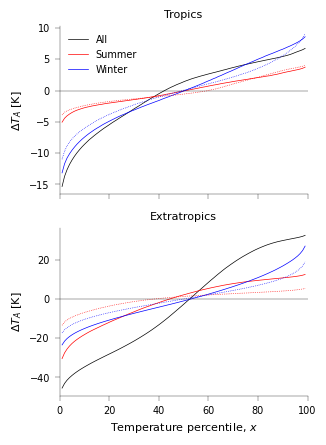

In [16]:
season_colours = {'all': 'k', '6_summer': 'red', '3_summer': 'red', '6_winter': 'blue', '3_winter': 'blue'}
season_labels = {'all': 'All', '6_summer': 'Summer', '3_summer': None, '6_winter': 'Winter', '3_winter': None}
temp_adiabat_anom = {key1: {key2: temp_adiabat_quant3[key1][key2]-temp_adiabat_mean[key1][key2][:, np.newaxis] 
                            for key2 in ds_all['tropics']} for key1 in ds_all}

save_temp_adiabat_anom_fig = True
fig, ax = plt.subplots(n_regions,1, figsize=(width['one_col'], n_regions*width['one_col']/ar), sharex=True)
for i, key1 in enumerate(ds_all):
    for j, key2 in enumerate(ds_all['tropics']):
        ax[i].plot(quantiles_all, np.average(temp_adiabat_anom[key1][key2], axis=0, weights=lat_weights[key1]), 
                   color=season_colours[key2], linestyle=':' if '3' in key2 else '-', label=season_labels[key2])
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].set_ylabel('$\Delta T_A$ [K]')
    ax[i].set_title(key1.capitalize())
ax[-1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
ax[0].legend()

if save_temp_adiabat_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_adiabat_anom_seasons.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Saturation Specific Humidity Anomaly Approximation

Here, the actual $\Delta q^*_A(x)$ is shown by solid thin lines, while the approximation $\Delta q_A(x) \approx \overline{\alpha_A}\overline{q^*_A}\Delta T_A$ is shown by the thick transparent lines.
Dotted lines are 3 month seasons, while solid are 6.

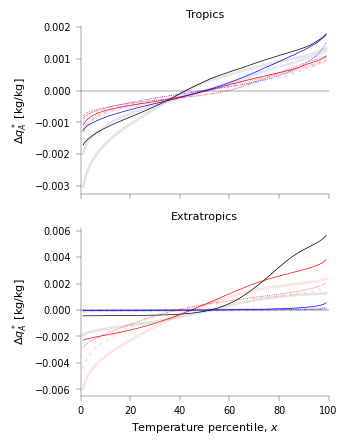

In [13]:
q_sat_anom = {key1: {key2: sphum_sat(temp_adiabat_quant3[key1][key2], pressure_ft_actual) - 
                           sphum_sat(temp_adiabat_mean[key1][key2], pressure_ft_actual)[:, np.newaxis] for key2 in ds_all['tropics']} for key1 in ds_all}
q_sat_anom_approx = {key1: {key2: (clausius_clapeyron_factor(temp_adiabat_mean[key1][key2], pressure_ft_actual) * 
                                   sphum_sat(temp_adiabat_mean[key1][key2], pressure_ft_actual))[:, np.newaxis] * 
                                  temp_adiabat_anom[key1][key2] for key2 in ds_all['tropics']} for key1 in ds_all}

save_q_sat_anom_approx_fig = False
fig, ax = plt.subplots(n_regions,1, figsize=(width['one_col'], n_regions*width['one_col']/ar), sharex=True)
for i, key1 in enumerate(ds_all):
    for j, key2 in enumerate(ds_all['tropics']):
        ax[i].plot(quantiles_all, np.average(q_sat_anom[key1][key2], axis=0, weights=lat_weights[key1]), 
                   color=season_colours[key2], linestyle=':' if '3' in key2 else '-')
        ax[i].plot(quantiles_all, np.average(q_sat_anom_approx[key1][key2], axis=0, weights=lat_weights[key1]), 
                   color=season_colours[key2], linestyle=':' if '3' in key2 else '-', lw=2, alpha=0.1)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].set_ylabel('$\Delta q^*_A$ [kg/kg]')
    ax[i].set_title(key1.capitalize())
ax[-1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

if save_fig or save_q_sat_anom_approx_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/q_sat_approx_seasons0.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

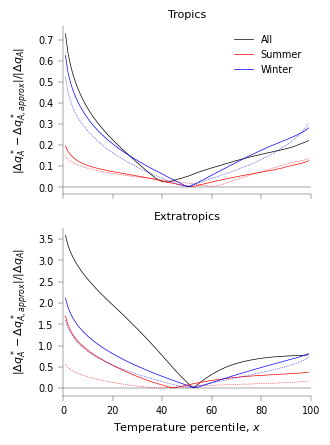

In [17]:
save_q_sat_anom_approx_norm_fig = True
fig, ax = plt.subplots(n_regions,1, figsize=(width['one_col'], n_regions*width['one_col']/ar), sharex=True)
for i, key1 in enumerate(ds_all):
    for j, key2 in enumerate(ds_all['tropics']):
        ax[i].plot(quantiles_all, np.average((q_sat_anom[key1][key2] - q_sat_anom_approx[key1][key2])/np.abs(q_sat_anom[key1][key2]), axis=0, weights=lat_weights[key1]), 
                   color=season_colours[key2], linestyle=':' if '3' in key2 else '-', label=season_labels[key2])
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].set_ylabel('$|\Delta q^*_A - \Delta q^*_{A, approx}| / |\Delta q_A|$')
    ax[i].set_title(key1.capitalize())
ax[-1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
ax[0].legend()

if save_fig or save_q_sat_anom_approx_norm_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/q_sat_approx_seasons.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)